# Dynamic Control Theory using Deep learning: Disease model

We model our disease model as differential equations to determine susceptible, exposed, infected and recovered people in a community.  

We will construct a neural network in order to determine the actual parameters of our model. We seek to predict the evolution of S^n, I^n, E^n, R^n by determining our parameters (control variables): µ^n, β^n, ϵ^n, Υ^n and α^n. Control variables are chosen so that the difference between actual and predicted state variables.


## Setting up our problem
We construct our dataset representing our actual observations. We build a neural networks that seeks to converge to our actual dataset

In [1]:
from keras import Model
from keras import layers
from keras import Input
from keras import optimizers
from keras import callbacks
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from scipy.stats import norm



#initializing vectors to store data in it
size=30
S=[]
E=[]
I=[]
R=[]
a1=[None]*size
Dec_r=[None]*size
Death_r=[None]*size
Expo_r=[None]*size
Inf_r=[None]*size
Rec_r=[None]*size
S_p=[None]*size
E_p=[None]*size
I_p=[None]*size
R_p=[None]*size
Diff=[None]*size

#iniializing delta t and birth rate
dt=1.
birth_r=0.04


#Constructing a random real data for 30 days
S.append(random.uniform(40.,50.))
E.append(random.uniform(28.,S[0]))
I.append(random.uniform(22.,E[0]))
R.append(random.uniform(19.,I[0]))
for i in range (size):
    S.append(S[i]+dt*(birth_r-random.uniform(0.,1)*S[i]-random.uniform(0.,1)*S[i]))
    E.append(E[i]+dt*(random.uniform(0.,1)*S[i]-(random.uniform(0.,1)+random.uniform(0.,1))*E[i]))
    I.append(I[i]+dt*(random.uniform(0.,1)*E[i]-(random.uniform(0.,1)+random.uniform(0.,1)+random.uniform(0.,1))*I[i]))
    R.append(R[i]+dt*(random.uniform(0.,1)*I[i]-random.uniform(0.,1)*R[i]))

print('Model is setup! \n')



Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
Model is setup! 



## Fitting our neural network:
We seek to predict our disease model state variables for the next 25 days.
We construct and deep network and minimize the difference between the actual/predicted data

In [2]:
'''
We construct our Neural network to predict S,E,I,R for the next 25 days
'''

input1=Input(shape=(1,),name='initial_S')

a1[0]=layers.Dense(15,activation='relu',use_bias=False,name='dense110')(input1)
a1[0]=layers.Dense(15,activation='relu',use_bias=False,name='dense120')(a1[0])
    
Dec_r[0]=layers.Dense(1,activation='sigmoid',use_bias=False,name='deceased_0')(a1[0])
Expo_r[0]=layers.Dense(1,activation='sigmoid',use_bias=False,name='exposed_0')(a1[0])
Inf_r[0]=layers.Dense(1,activation='sigmoid',use_bias=False,name='infected_0')(a1[0])
Rec_r[0]=layers.Dense(1,activation='sigmoid',use_bias=False,name='recovered_0')(a1[0])
Death_r[0]=layers.Dense(1,activation='sigmoid',use_bias=False,name='death_0')(a1[0])



S_p[0]=layers.Lambda(lambda x:S[0]+dt*(birth_r-x[0]*S[0]-x[1]*S[0]),name='S_p_0')([Dec_r[0],Expo_r[0]])
E_p[0]=layers.Lambda(lambda x:E[0]+dt*(x[0]*S[0]-(x[1]+x[2])*E[0]),name='E_p_0')([Expo_r[0],Dec_r[0],Inf_r[0]])
I_p[0]=layers.Lambda(lambda x:I[0]+dt*(x[0]*E[0]-(x[1]+x[2]+x[3])*I[0]),name='I_p_0')([Inf_r[0],Rec_r[0],Dec_r[0],Death_r[0]])
R_p[0]=layers.Lambda(lambda x:R[0]+dt*(x[0]*I[0]-x[1]*R[0]),name='R_p_0')([Rec_r[0],Death_r[0]])

Diff[0]=layers.Lambda(lambda x:(((x[0]-S[1])**2)+((x[1]-E[1])**2)+((x[2]-I[1])**2)+((x[3]-R[1])**2))**0.5,name='Diff_0')([S_p[0],E_p[0],I_p[0],R_p[0]])
    
    
periods=25
for i in range(1,periods):
        
    a1[i]=layers.Dense(15,activation='relu',use_bias=False,name=('dense11%s'%str(i)))(R_p[i-1])
    a1[i]=layers.Dense(15,activation='relu',use_bias=False,name=('dense12%s'%str(i)))(a1[i])
    
    #determine props
    Dec_r[i]=layers.Dense(1,activation='sigmoid',use_bias=False,name=('deceased_%s'%str(i)))(a1[i])
    Expo_r[i]=layers.Dense(1,activation='sigmoid',use_bias=False,name=('exposed_%s'%str(i)))(a1[i])
    Inf_r[i]=layers.Dense(1,activation='sigmoid',use_bias=False,name=('infected_%s'%str(i)))(a1[i])
    Rec_r[i]=layers.Dense(1,activation='sigmoid',use_bias=False,name=('recovered_%s'%str(i)))(a1[i])
    Death_r[i]=layers.Dense(1,activation='sigmoid',use_bias=False,name=('death_%s'%str(i)))(a1[i])



    S_p[i]=layers.Lambda(lambda x:x[2]+dt*(birth_r-x[0]*S[2]-x[1]*S[2]),name=('S_p_%s'%str(i)))([Dec_r[i],Expo_r[i],S_p[i-1]])
    E_p[i]=layers.Lambda(lambda x:x[3]+dt*(x[0]*x[4]-(x[1]+x[2])*x[3]),name=('E_p_%s'%str(i)))([Expo_r[i],Dec_r[i],Inf_r[i],E_p[i-1],S_p[i-1]])
    I_p[i]=layers.Lambda(lambda x:x[4]+dt*(x[0]*x[5]-(x[1]+x[2]+x[3])*x[4]),name=('I_p_%s'%str(i)))([Inf_r[i],Rec_r[i],Dec_r[i],Death_r[i],I_p[i-1],E_p[i-1]])
    R_p[i]=layers.Lambda(lambda x:x[2]+dt*(x[0]*x[3]-x[1]*x[2]),name=('R_p_%s'%str(i)))([Rec_r[i],Death_r[i],R_p[i-1],I_p[i-1]])

    Diff[i]=layers.Lambda(lambda x:x[4]+((x[0]-S[i+1])**2+(x[1]-E[i+1])**2+(x[2]-I[i+1])**2+(x[3]-R[i+1])**2)**0.5,name=('Diff_%s'%str(i)))([S_p[i],E_p[i],I_p[i],R_p[i],Diff[i-1]])
    
    
    
# compiling our model    
model_t1 =Model(input1, Diff[i], name="model_t1")
model_t1.summary()
initial_t0=np.array([S[0]])
target=np.array([0.0])   
opt = tf.keras.optimizers.Adam(lr=0.00015)
model_t1.compile(optimizer=opt,loss="mean_absolute_error")
history=model_t1.fit(x=initial_t0,y=target,epochs=15000,verbose=1)  



#Extract Useful output

inter_lay_model_Sp = Model(inputs=model_t1.input,
                                    outputs=S_p[:periods-1])
intermediate_Sp = inter_lay_model_Sp.predict(initial_t0)
    

inter_lay_model_Ep = Model(inputs=model_t1.input,
                                    outputs=E_p[:periods-1])
intermediate_Ep = inter_lay_model_Ep.predict(initial_t0)

inter_lay_model_Ip = Model(inputs=model_t1.input,
                                    outputs=I_p[:periods-1])
intermediate_Ip = inter_lay_model_Ip.predict(initial_t0)

inter_lay_model_Rp = Model(inputs=model_t1.input,
                                    outputs=R_p[:periods-1])
intermediate_Rp = inter_lay_model_Rp.predict(initial_t0)
    
inter_lay_model_diff = Model(inputs=model_t1.input,
                                    outputs=Diff[:periods-1])
intermediate_diff = inter_lay_model_diff.predict(initial_t0)




   

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_t1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
initial_S (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
dense110 (Dense)                (None, 15)           15          initial_S[0][0]                  
__________________________________________________________________________________________________
dense120 (Dense)                (None, 15)           225         dense110[0][0]                   
__________________________________________________________________________________________________
recovered_0 (Dense)             (None, 1)            15          dense120[0][0]                   
__________

## Summarizing findings through graphs

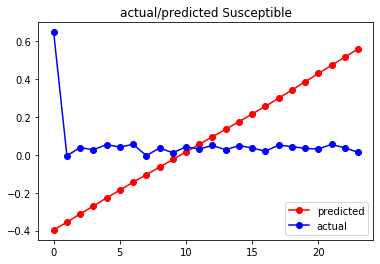

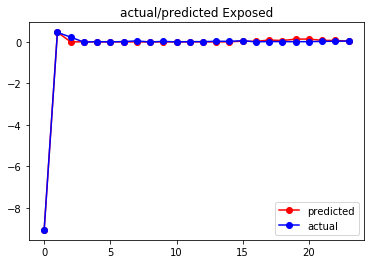

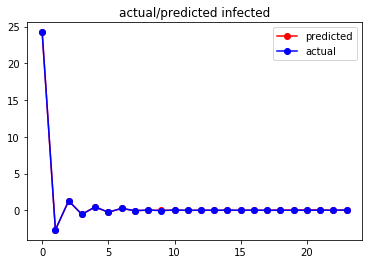

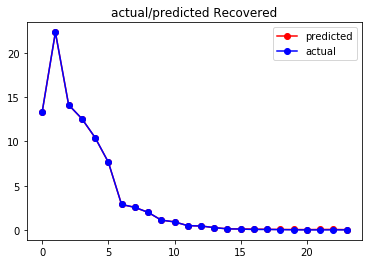

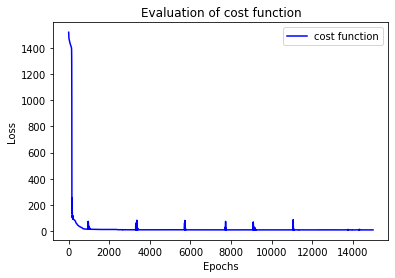

In [3]:
#Plot useful graphs
intermediate_Sp = np.reshape(intermediate_Sp,(periods-1,)).T
x=np.array(np.arange(periods-1))

plt.plot(x,intermediate_Sp,'-o',c='red',label='predicted')
plt.plot(x,S[1:i+1],'-o',c='blue',label='actual')
plt.title("actual/predicted Susceptible")
plt.legend()
plt.show()


intermediate_Ep = np.reshape(intermediate_Ep,(periods-1,)).T
x=np.array(np.arange(periods-1))

plt.plot(x,intermediate_Ep,'-o',c='red',label='predicted')
plt.plot(x,E[1:i+1],'-o',c='blue',label='actual')
plt.title("actual/predicted Exposed")
plt.legend()
plt.show()

intermediate_Ip = np.reshape(intermediate_Ip,(periods-1,)).T
x=np.array(np.arange(periods-1))

plt.plot(x,intermediate_Ip,'-o',c='red',label='predicted')
plt.plot(x,I[1:i+1],'-o',c='blue',label='actual')
plt.title("actual/predicted infected")
plt.legend()
plt.show()

intermediate_Rp = np.reshape(intermediate_Rp,(periods-1,)).T
x=np.array(np.arange(periods-1))

plt.plot(x,intermediate_Rp,'-o',c='red',label='predicted')
plt.plot(x,R[1:i+1],'-o',c='blue',label='actual')
plt.title("actual/predicted Recovered")
plt.legend()
plt.show()


#loss evolution

history_dict = history.history
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='cost function')
#plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Evaluation of cost function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()